Training PyTorch model with SGD...
Training PyTorch model with SGD+Momentum...
Training PyTorch model with SGD+Nesterov...
Training PyTorch model with Adagrad...
Training PyTorch model with RMSprop...
Training PyTorch model with Adam...
Training TensorFlow model with SGD...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/90/4001hvgn0m31_pyw0p80brbr0000gn/T/ipykernel_72421/4062581708.py:193: RuntimeWarning: overflow encountered in square
  train_loss = np.mean((train_pred - y_train.numpy()) ** 2)
/var/folders/90/4001hvgn0m31_pyw0p80brbr0000gn/T/ipykernel_72421/4062581708.py:197: RuntimeWarning: overflow encountered in square
  test_loss = np.mean((test_pred - y_test.numpy()) ** 2)
/var/folders/90/4001hvgn0m31_pyw

Training TensorFlow model with SGD+Momentum...
Training TensorFlow model with SGD+Nesterov...
Training TensorFlow model with Adagrad...
Training TensorFlow model with RMSprop...
Training TensorFlow model with Adam...


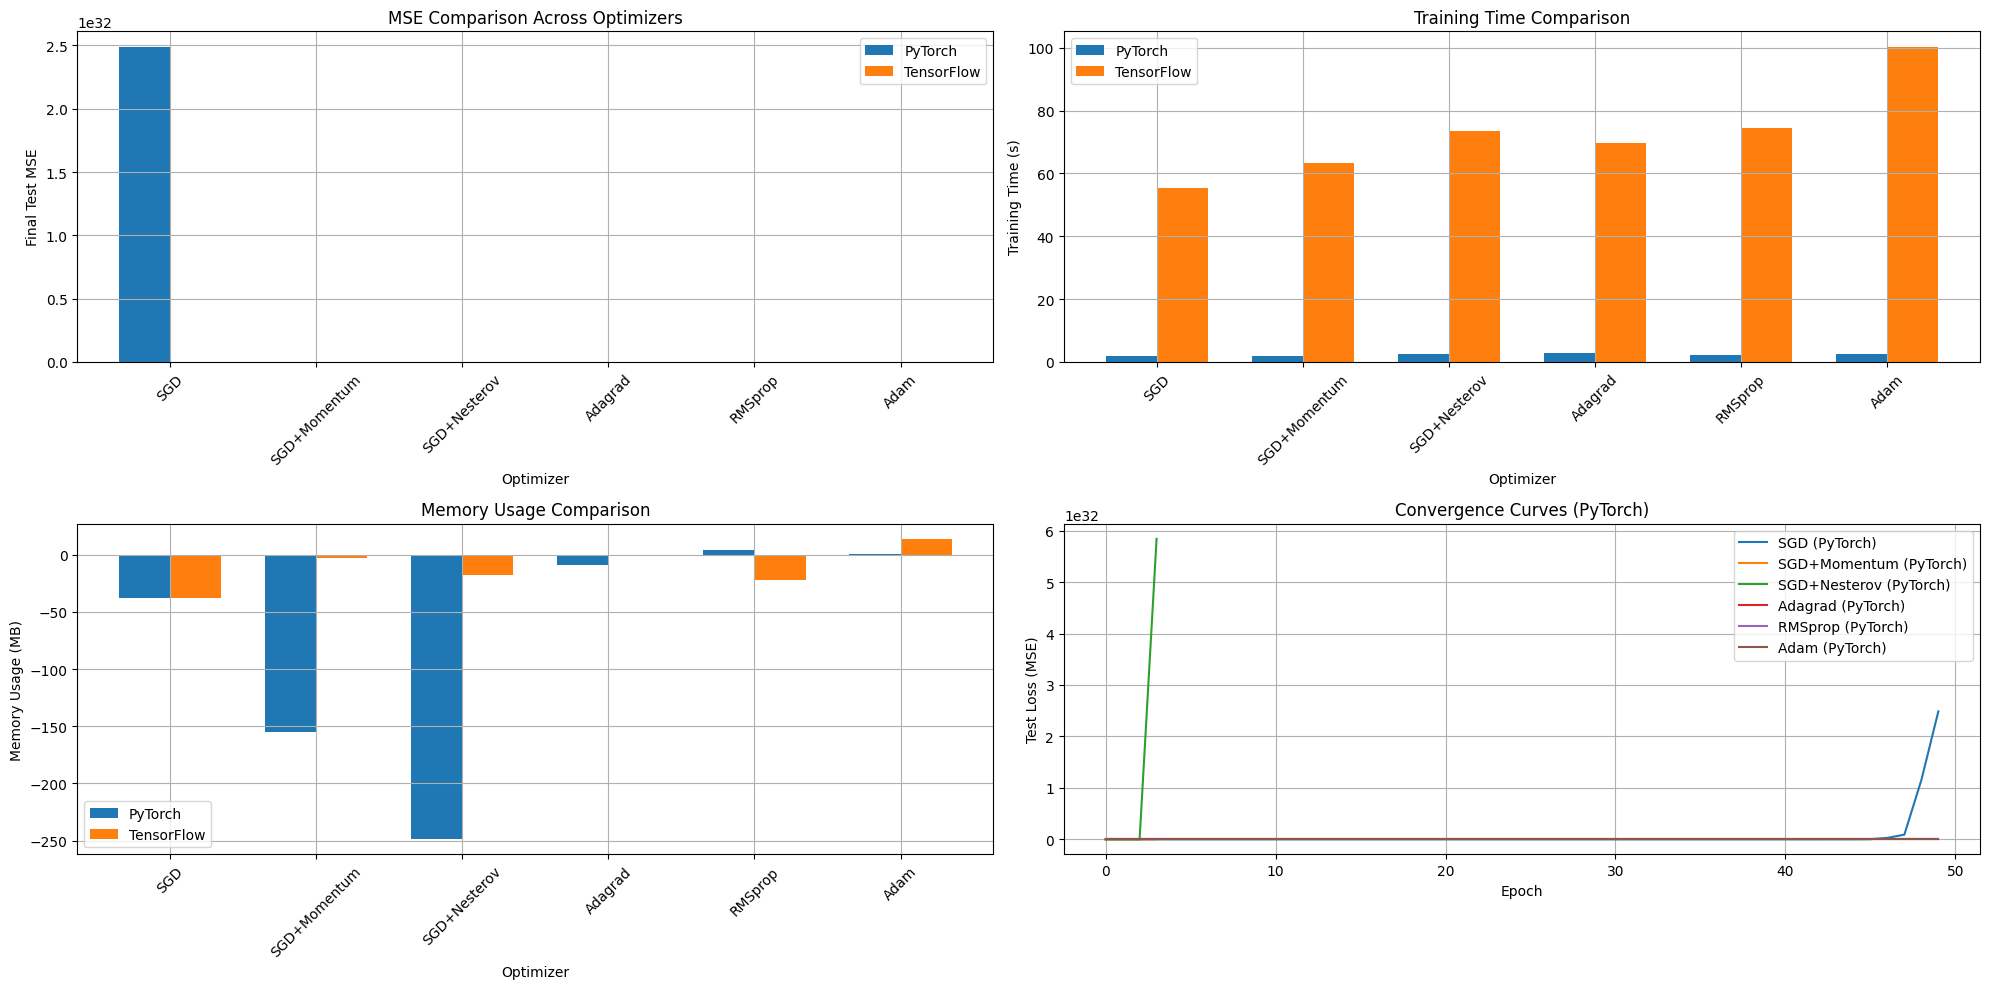

Optimization Comparison Results:
--------------------------------------------------------------------------------
Optimizer       Framework    Final MSE    Training Time   Memory (MB) 
--------------------------------------------------------------------------------
SGD             PyTorch      248720626278956608761023566970880.000000 1.886529s -37.72
SGD+Momentum    PyTorch      nan 1.967321s -154.94
SGD+Nesterov    PyTorch      nan 2.567658s -248.80
Adagrad         PyTorch      0.567478 2.950758s -9.25
RMSprop         PyTorch      0.547425 2.336082s 3.59
Adam            PyTorch      0.558680 2.479066s 0.56
SGD             TensorFlow   inf 55.225018s -38.38
SGD+Momentum    TensorFlow   nan 63.450760s -2.98
SGD+Nesterov    TensorFlow   nan 73.469791s -17.77
Adagrad         TensorFlow   0.681838 69.611514s -0.73
RMSprop         TensorFlow   0.637064 74.563935s -21.91
Adam            TensorFlow   0.549358 100.202089s 13.72


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from keras.losses import mean_squared_error
from src.data import load_california
import time
import psutil

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

# Load and prepare data
X, y = load_california(scale=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors for PyTorch
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(y_train.reshape(-1, 1))
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.FloatTensor(y_test.reshape(-1, 1))

# Convert to tensors for TensorFlow
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test.reshape(-1, 1), dtype=tf.float32)

# Common parameters
epochs = 50
batch_size = 32
learning_rate = 0.01

# PyTorch model
class LinearRegressionTorch(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Function to train PyTorch model
def train_torch_model(optimizer_name, X_train, y_train, X_test, y_test):
    input_dim = X_train.shape[1]
    model = LinearRegressionTorch(input_dim)

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD+Momentum":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == "SGD+Nesterov":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_name == "Adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Memory before training
    proc = psutil.Process()
    mem_before = proc.memory_info().rss

    # Start time
    start_time = time.time()

    # Training loop
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Mini-batch training
        indices = torch.randperm(X_train.shape[0])

        for i in range(0, X_train.shape[0], batch_size):
            batch_indices = indices[i:i+batch_size]
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate model
        with torch.no_grad():
            train_pred = model(X_train)
            train_loss = criterion(train_pred, y_train).item()
            train_losses.append(train_loss)

            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test).item()
            test_losses.append(test_loss)

    # End time
    training_time = time.time() - start_time

    # Memory after training
    mem_after = proc.memory_info().rss
    memory_used = mem_after - mem_before

    # Final test MSE
    with torch.no_grad():
        test_pred = model(X_test)
        final_mse = criterion(test_pred, y_test).item()

    return {
        'optimizer': optimizer_name,
        'framework': 'PyTorch',
        'final_mse': final_mse,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'training_time': training_time,
        'memory_used': memory_used
    }

# TensorFlow model
def create_tf_model(input_dim):
    model = keras.Sequential([
        keras.layers.Dense(1, input_shape=(input_dim,))
    ])
    return model

# Function to train TensorFlow model
def train_tf_model(optimizer_name, X_train, y_train, X_test, y_test):
    input_dim = X_train.shape[1]
    model = create_tf_model(input_dim)

    # Optimizer
    if optimizer_name == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == "SGD+Momentum":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_name == "SGD+Nesterov":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_name == "Adagrad":
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(optimizer=optimizer, loss='mse')

    # Memory before training
    proc = psutil.Process()
    mem_before = proc.memory_info().rss

    # Start time
    start_time = time.time()

    # Training history container
    train_losses = []
    test_losses = []

    # Training loop (manual to match PyTorch implementation)
    for epoch in range(epochs):
        # Shuffle data
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train.numpy()[indices]
        y_shuffled = y_train.numpy()[indices]

        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            with tf.GradientTape() as tape:
                predictions = model(X_batch, training=True)
                loss = mean_squared_error(y_batch, predictions)
                loss = tf.reduce_mean(loss)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Evaluate model
        train_pred = model.predict(X_train, verbose=0)
        train_loss = np.mean((train_pred - y_train.numpy()) ** 2)
        train_losses.append(train_loss)

        test_pred = model.predict(X_test, verbose=0)
        test_loss = np.mean((test_pred - y_test.numpy()) ** 2)
        test_losses.append(test_loss)

    # End time
    training_time = time.time() - start_time

    # Memory after training
    mem_after = proc.memory_info().rss
    memory_used = mem_after - mem_before

    # Final test MSE
    test_pred = model.predict(X_test, verbose=0)
    final_mse = np.mean((test_pred - y_test.numpy()) ** 2)

    return {
        'optimizer': optimizer_name,
        'framework': 'TensorFlow',
        'final_mse': final_mse,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'training_time': training_time,
        'memory_used': memory_used
    }

# Run experiments
optimizers = ["SGD", "SGD+Momentum", "SGD+Nesterov", "Adagrad", "RMSprop", "Adam"]
results = []

# PyTorch experiments
for opt in optimizers:
    print(f"Training PyTorch model with {opt}...")
    result = train_torch_model(opt, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
    results.append(result)

# TensorFlow experiments
for opt in optimizers:
    print(f"Training TensorFlow model with {opt}...")
    result = train_tf_model(opt, X_train_tf, y_train_tf, X_test_tf, y_test_tf)
    results.append(result)

# Plot results
def plot_optimization_comparison(results):
    plt.figure(figsize=(20, 10))

    # Plot 1: MSE comparison
    plt.subplot(2, 2, 1)
    torch_results = [r for r in results if r['framework'] == 'PyTorch']
    tf_results = [r for r in results if r['framework'] == 'TensorFlow']

    opt_names = [r['optimizer'] for r in torch_results]
    torch_mse = [r['final_mse'] for r in torch_results]
    tf_mse = [r['final_mse'] for r in tf_results]

    x = np.arange(len(opt_names))
    width = 0.35

    plt.bar(x - width/2, torch_mse, width, label='PyTorch')
    plt.bar(x + width/2, tf_mse, width, label='TensorFlow')
    plt.xlabel('Optimizer')
    plt.ylabel('Final Test MSE')
    plt.title('MSE Comparison Across Optimizers')
    plt.xticks(x, opt_names, rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot 2: Training time comparison
    plt.subplot(2, 2, 2)
    torch_time = [r['training_time'] for r in torch_results]
    tf_time = [r['training_time'] for r in tf_results]

    plt.bar(x - width/2, torch_time, width, label='PyTorch')
    plt.bar(x + width/2, tf_time, width, label='TensorFlow')
    plt.xlabel('Optimizer')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time Comparison')
    plt.xticks(x, opt_names, rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot 3: Memory usage comparison
    plt.subplot(2, 2, 3)
    torch_mem = [r['memory_used']/1024/1024 for r in torch_results]  # Convert to MB
    tf_mem = [r['memory_used']/1024/1024 for r in tf_results]  # Convert to MB

    plt.bar(x - width/2, torch_mem, width, label='PyTorch')
    plt.bar(x + width/2, tf_mem, width, label='TensorFlow')
    plt.xlabel('Optimizer')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage Comparison')
    plt.xticks(x, opt_names, rotation=45)
    plt.legend()
    plt.grid(True)

    # Plot 4: Convergence curves (only for first PyTorch optimizer to avoid clutter)
    plt.subplot(2, 2, 4)
    for i, r in enumerate(torch_results):
        plt.plot(r['test_losses'], label=f"{r['optimizer']} (PyTorch)")
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss (MSE)')
    plt.title('Convergence Curves (PyTorch)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Display results
plot_optimization_comparison(results)

# Create a detailed comparison table
def print_comparison_table(results):
    print("Optimization Comparison Results:")
    print("-" * 80)
    print(f"{'Optimizer':<15} {'Framework':<12} {'Final MSE':<12} {'Training Time':<15} {'Memory (MB)':<12}")
    print("-" * 80)

    for r in results:
        print(f"{r['optimizer']:<15} {r['framework']:<12} {r['final_mse']:.6f} {r['training_time']:.6f}s {r['memory_used']/1024/1024:.2f}")

print_comparison_table(results)